In [ ]:
%run D:\codes\ukmo\read_ukmo.ipynb
%run D:\codes\confg

In [1]:
%%capture
import warnings

import xarray as xr

import metpy
import metpy.calc as mpcalc
import numpy as np
import pandas as pd
import wrf
from matplotlib import pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
from netCDF4 import Dataset
    
warnings.filterwarnings("ignore")

In [2]:
def get_ukmo_level(city_name=None, lat=None, lon=None):
    """read in UKMO Model at a fixed point and select the lowest level, either with city_name or with (lat, lon)"""
    if city_name is not None:
        lat, lon = get_coordinates_by_station_name(city_name)

    xi, yi = get_rotated_index_of_lat_lon(latitude=lat, longitude=lon)

    df = pd.DataFrame()
    for var in ["u", "v", "w", "z", "th", "q", "p"]:
        data = xr.open_dataset(f"{ukmo_folder}/MetUM_MetOffice_20171015T1200Z_CAP02_3D_30min_1km_optimal_{var}.nc")
        dat = data.sel(time=slice("2017-10-15T14:00:00", "2017-10-16T12:00:00.000000000"))
        
        #HERE CHANGE FOR OTHER LEVELS
        data_final = dat.isel(grid_latitude=yi, grid_longitude=xi, model_level_number=0, bnds=1) 

        # print(data_final["level_height"].values) # u and v are on 2.5 m, all other variables at 5m

        if var == "v":
            df["transformed_y_wind"] = data_final["transformed_y_wind"]
            df.set_index(data_final["time"].values, inplace=True)

        elif var == "u":
            df["transformed_x_wind"] = data_final["transformed_x_wind"]

        elif var == "w":
            df["upward_air_velocity"] = data_final["upward_air_velocity"]
        elif var == "z":
            df["geopotential_height"] = data_final["geopotential_height"]
        elif var == "th":
            df["air_potential_temperature"] = data_final["air_potential_temperature"]
        elif var == "q":
            df["specific_humidity"] = data_final["specific_humidity"]
        elif var == "p":
            df["air_pressure"] = data_final["air_pressure"]

    # convert variables
    temp_pot = df["air_potential_temperature"].values * units("K")
    pres = df["air_pressure"].values * units("Pa")

    df["temperature"] = mpcalc.temperature_from_potential_temperature(pres,
                                                                      temp_pot).magnitude - 273.15  # convert it to celsius

    df["specific_humidity"] = df["specific_humidity"] * 1000  # from kg / kg in g/kg
    u_icon = df["transformed_x_wind"].values * units("m/s")
    v_icon = df["transformed_y_wind"].values * units("m/s")

    df["wind_dir"] = mpcalc.wind_direction(u_icon, v_icon, convention='from')
    df["windspeed"] = mpcalc.wind_speed(u_icon, v_icon)

    temp_C = df["temperature"].values * units("degC")

    specific_humidity = df["specific_humidity"].values * units("g/kg")

    df["relative_humidity"] = mpcalc.relative_humidity_from_specific_humidity(pres.to(units.hPa), temp_C.to(units.K),
                                                                              specific_humidity).to("percent")
    return df

45

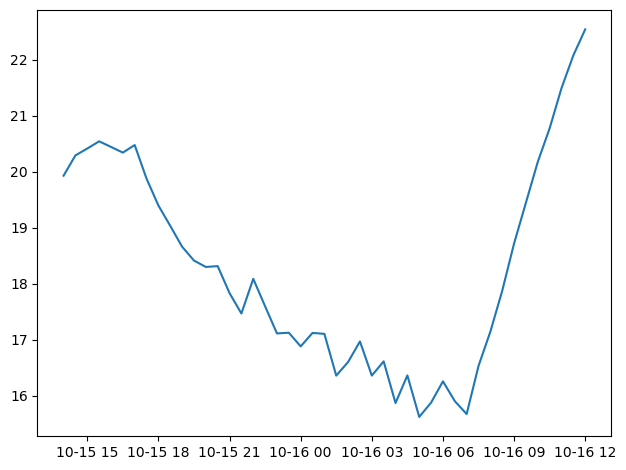

In [3]:
um_lowest_level = get_ukmo_level(lat=47.2598, lon=11.3553) #LOWI
plt.plot(um_lowest_level.index, um_lowest_level.temperature)
plt.tight_layout()
len(um_lowest_level.temperature)